In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Speciation Time Test

In [3]:
def test_speciation_time(
    algorithm, speciation=0.001, seeds=[42], radius=25, sample=1.0
):
    total_pvalues = []
    total_speciations = []
    
    for seed in seeds:
        # Configure the simulation
        # (tested on almost infinite with sigma 0 to avoid bias from coalescence)
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: 0.0,
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalSpeciation(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, radius=radius,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        speciations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        speciations = []
        with speciations_io:
            reader = csv.reader(speciations_io)
            next(reader)

            for row in reader:
                speciations.append(float(row[0]))
        speciations = np.array(speciations)

        # Calculate in the dispersal locations
        gof = kstest(speciations, expon(loc=0.0, scale=2.0/speciation).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_speciations.append(speciations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    display(Markdown("#### Speciation histograms:"))
    
    speciations = np.concatenate(total_speciations)
    
    # Draw the speciation time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(speciations), np.max(speciations), 1000)
    loc, scale = expon.fit(speciations)
    
    ax1.set_title(f"Individual speciation times PDF")
    ax1.set_xlabel("speciation time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax1.hist(speciations, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual speciation times CDF")
    ax2.set_xlabel("speciation time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax2.hist(speciations, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:


* p-value: 0.13385716584091997
* statistic: 27.05021393372983

#### Speciation histograms:

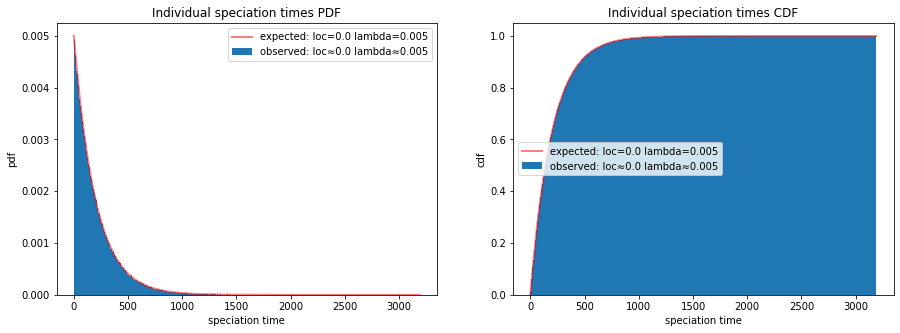

#### Parameters:
* seeds: [ 4320010379245261065  1221681469655604789 10602291008118684025
 15142906827239522868  2571358417132897518  9815613025475970394
  3196280273120312990  8282858356537380100 17493946475520673343
 10019563849877051850]

#### Configuration:
```rust
(speciation:0.01,seed:10019563849877051850,sample:0.1,algorithm:Classical(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.20705531259659934
* statistic: 24.85447554264994

#### Speciation histograms:

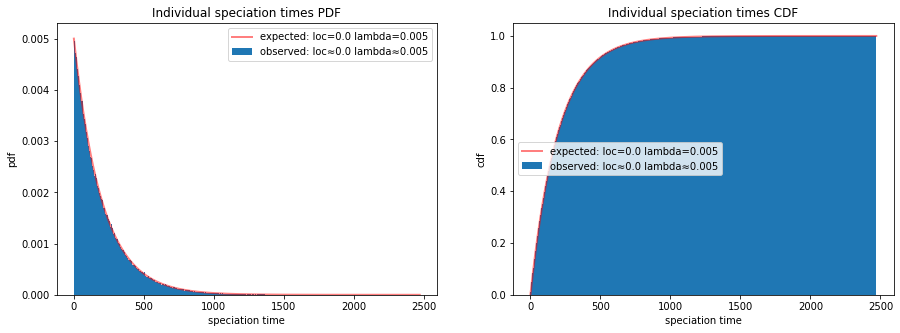

#### Parameters:
* seeds: [14331788138770420625  8860667545482602430 13530425416845798240
 13443999035544229779 16086860801952481094  8322198444744436205
  3395843589794309116  1928341509793302499   787725246023311619
 17674149858756429054]

#### Configuration:
```rust
(speciation:0.01,seed:17674149858756429054,sample:0.1,algorithm:Gillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.8651320819289036
* statistic: 13.27817847452954

#### Speciation histograms:

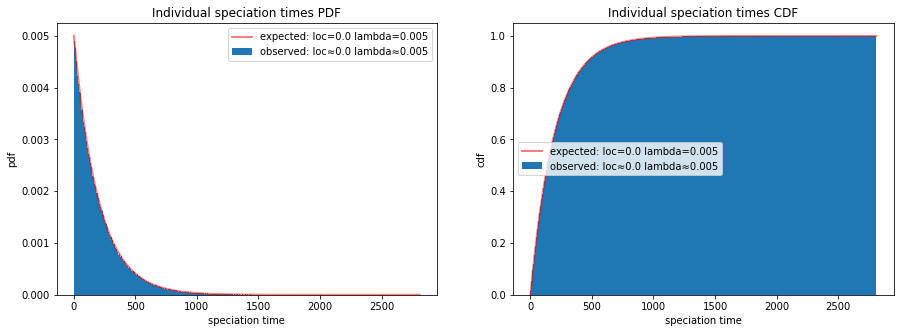

#### Parameters:
* seeds: [ 3883061855823645787  5492082150703604595 17665614421438667874
 17529943387476453676  8189752020632056179 10136637236412660671
  2977212240892260482 15953495377873756763 16456766369030535132
  5391520237464476221]

#### Configuration:
```rust
(speciation:0.01,seed:5391520237464476221,sample:0.1,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.7451512894621422
* statistic: 15.532824855147561

#### Speciation histograms:

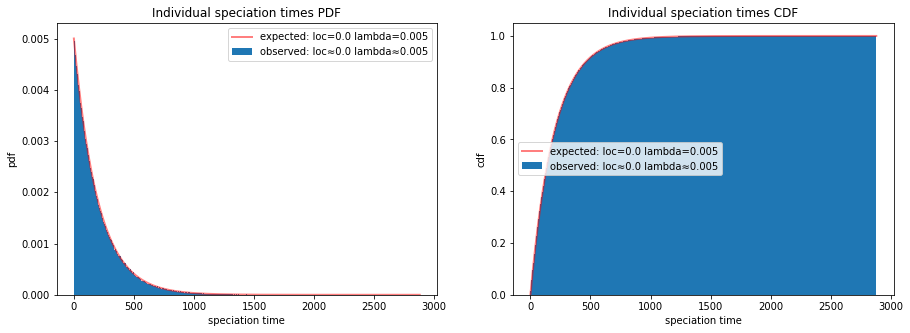

#### Parameters:
* seeds: [ 1792230691360357046  6032315634314918389 11637931555497494517
  4331508031683959578 15227846270504579013  6273614883680663855
  5924979888769725508 12015577760244514251 12549153765941592063
  6922517773072702879]

#### Configuration:
```rust
(speciation:0.01,seed:6922517773072702879,sample:0.1,algorithm:Independent(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)
    
    test_speciation_time(algorithm, speciation=0.01, seeds=seeds, radius=500, sample=0.1)